In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline


from wordcloud import WordCloud


from collections import Counter
import os
import numpy as np
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams    

import html
import unicodedata

stop_words = stopwords.words('english')
%config InlineBackend.figure_format = 'retina'


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [6]:
def wordcloud(text,ngram=1):
    wordcloud = WordCloud(width=1400, 
                            height=800,
                            random_state=2021,
                            background_color='black',
                            )
    if ngram ==1:
        wordc = wordcloud.generate(' '.join(text))
    else:
        wordc = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(12,6), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
      

def get_n_grans_count(text, n_grams, min_freq):
    output = {}
    tokens = nltk.word_tokenize(text)

    #Create the n_gram
    if n_grams == 2:
        gs = nltk.bigrams(tokens)
        
    elif n_grams == 3:
        gs = nltk.trigrams(tokens)

    else:
        return 'Only 2_grams and 3_grams are supported'
    
    # compute frequency distribution for all the bigrams in the text by threshold with min_freq
    fdist = nltk.FreqDist(gs)
    for k,v in fdist.items():
        if v > min_freq:
            index = ' '.join(k)
            output[index] = v
    
    return output
    
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text, and by defult lemmatize nouns"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem or lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

**Goal:building algorithms to rate the complexity of reading passages for grade 3-12 classroom use**

In [7]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
submission = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

train_data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


## EDA

In [8]:
train_data.describe()

,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


In [9]:
# showing if any feature has at least one null value
train_data.isnull().any()

id                False
url_legal          True
license            True
excerpt           False
target            False
standard_error    False
dtype: bool

In [10]:
# count null values
train_data.isnull().sum()

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

## Target and Standard Error Distributions

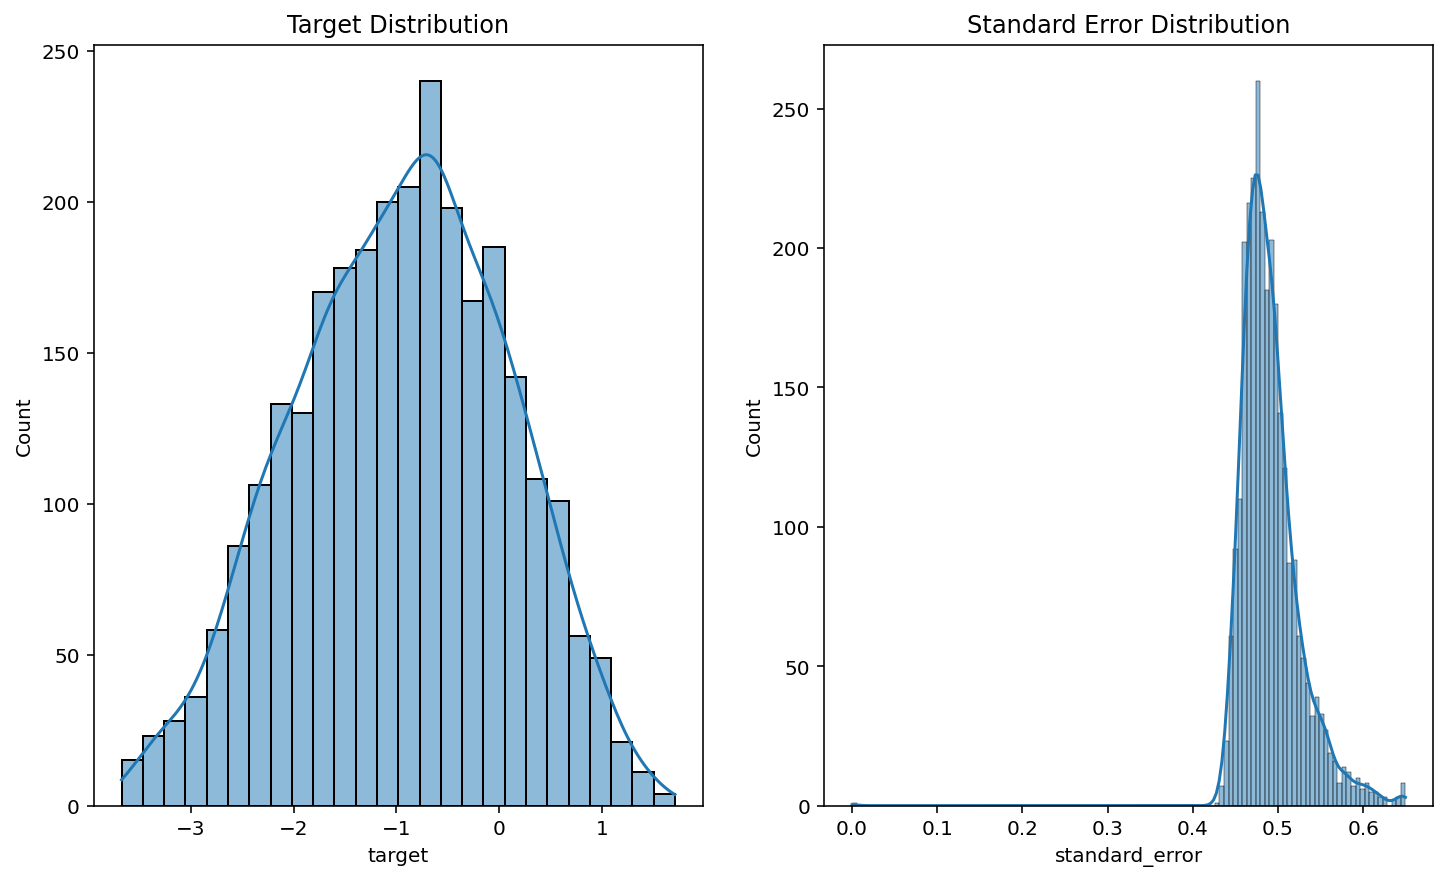

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,7))
sns.histplot(train_data['target'], kde= True, ax=ax[0])
sns.histplot(train_data['standard_error'], kde= True, ax=ax[1])
ax[0].set_title("Target Distribution")
ax[1].set_title("Standard Error Distribution")
plt.show();

## license

In [12]:
train_data['license'].value_counts()

CC BY 4.0                                 391
CC BY-SA 3.0 and GFDL                     196
CC BY-SA 3.0                              192
CC BY-NC-SA 2.0                            26
CC BY 3.0                                   7
CC BY-NC-SA 4.0                             4
CC BY-NC-ND 4.0                             3
CC BY NC-SA 2.0                             2
CC BY-NC-SA 3.0                             2
CC BY-NC                                    2
GNU Free Document License, version 1.2      1
CC BY-NC 2.0                                1
CC-BY-SA                                    1
CC BY-NC 3.0                                1
CC-BY-NC                                    1
Name: license, dtype: int64

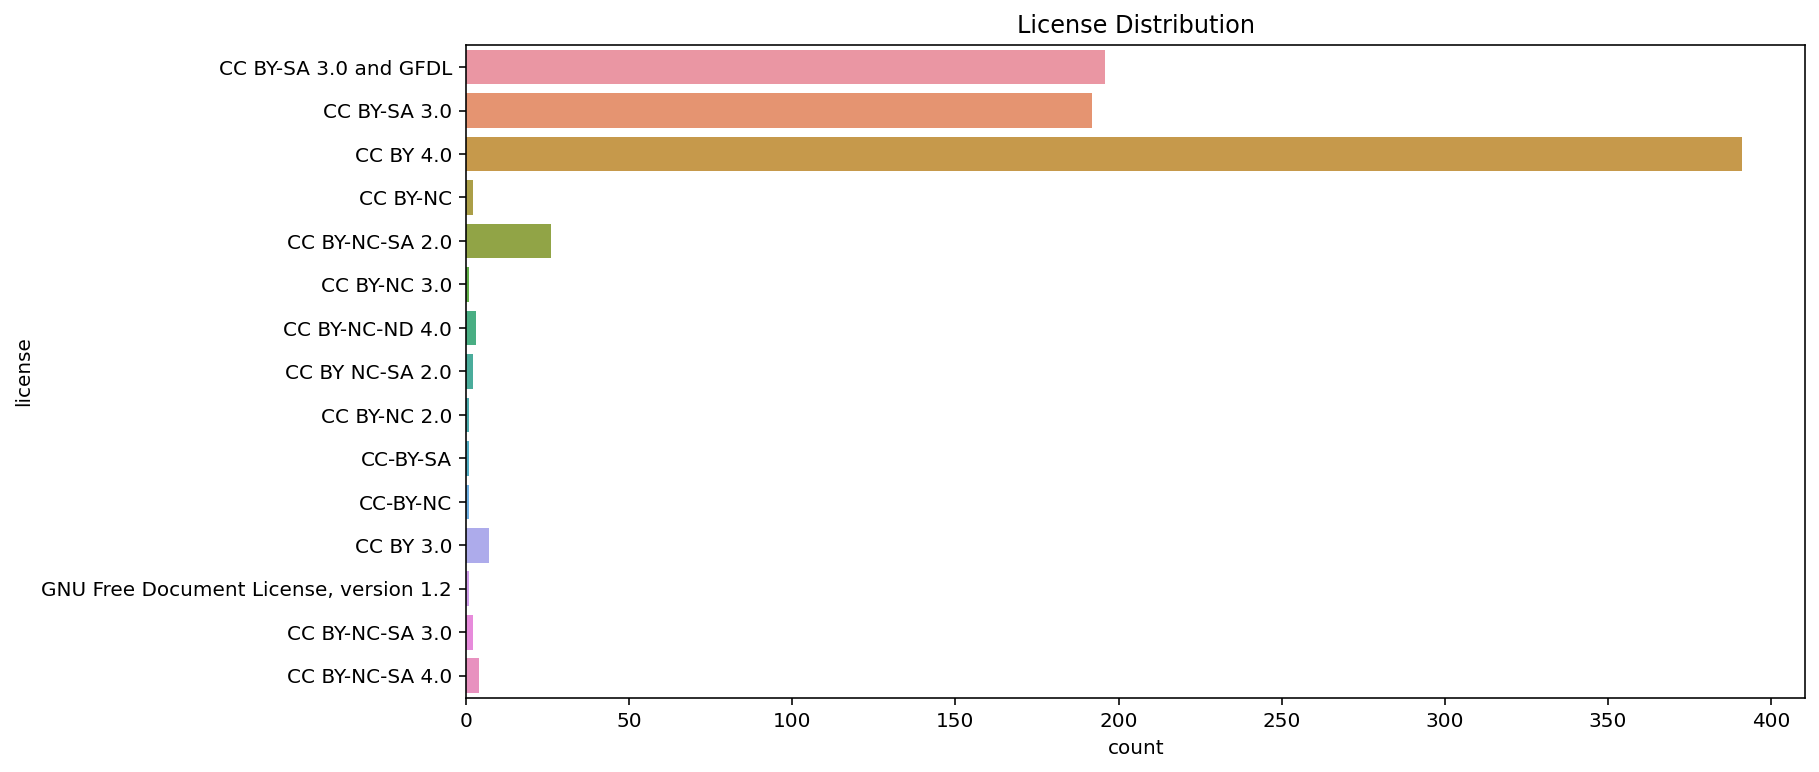

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(data= train_data, y= 'license')
plt.title('License Distribution')
plt.show();

## Url legal

In [14]:
# showing the shaper of url's
urls = train_data['url_legal'].dropna()
urls = [url for url in urls]
urls[:5]

['https://simple.wikipedia.org/wiki/Battle_of_Britain',
 'https://simple.wikipedia.org/wiki/Battle_of_Saratoga',
 'https://simple.wikipedia.org/wiki/Battle_of_Waterloo',
 'https://en.wikipedia.org/wiki/Big_data',
 'https://en.wikipedia.org/wiki/Biodiesel']

In [15]:
# Extract all url's
url_list = train_data['url_legal'].dropna().apply(lambda x : re.findall('https?://([A-Za-z_0-9.-]+).*',x)[0])
url_list = [url for url in url_list]
url_list[:10]

['simple.wikipedia.org',
 'simple.wikipedia.org',
 'simple.wikipedia.org',
 'en.wikipedia.org',
 'en.wikipedia.org',
 'en.wikipedia.org',
 'en.wikipedia.org',
 'kids.frontiersin.org',
 'en.wikipedia.org',
 'en.wikipedia.org']

In [16]:
# count url's and sort them descending order 
urls_counts = Counter(url_list)
urls_counts_sorted = sorted(urls_counts.items(), key=lambda pair: pair[1], reverse=True)
urls_counts_df = pd.DataFrame(urls_counts_sorted, columns=['sites', 'counts'])
urls_counts_df

,sites,counts
0,simple.wikipedia.org,196
1,kids.frontiersin.org,191
2,en.wikipedia.org,176
3,www.africanstorybook.org,164
4,www.commonlit.org,41
5,freekidsbooks.org,19
6,www.digitallibrary.io,19
7,en.wikibooks.org,8
8,static.ehe.osu.edu,6
9,drive.google.com,3


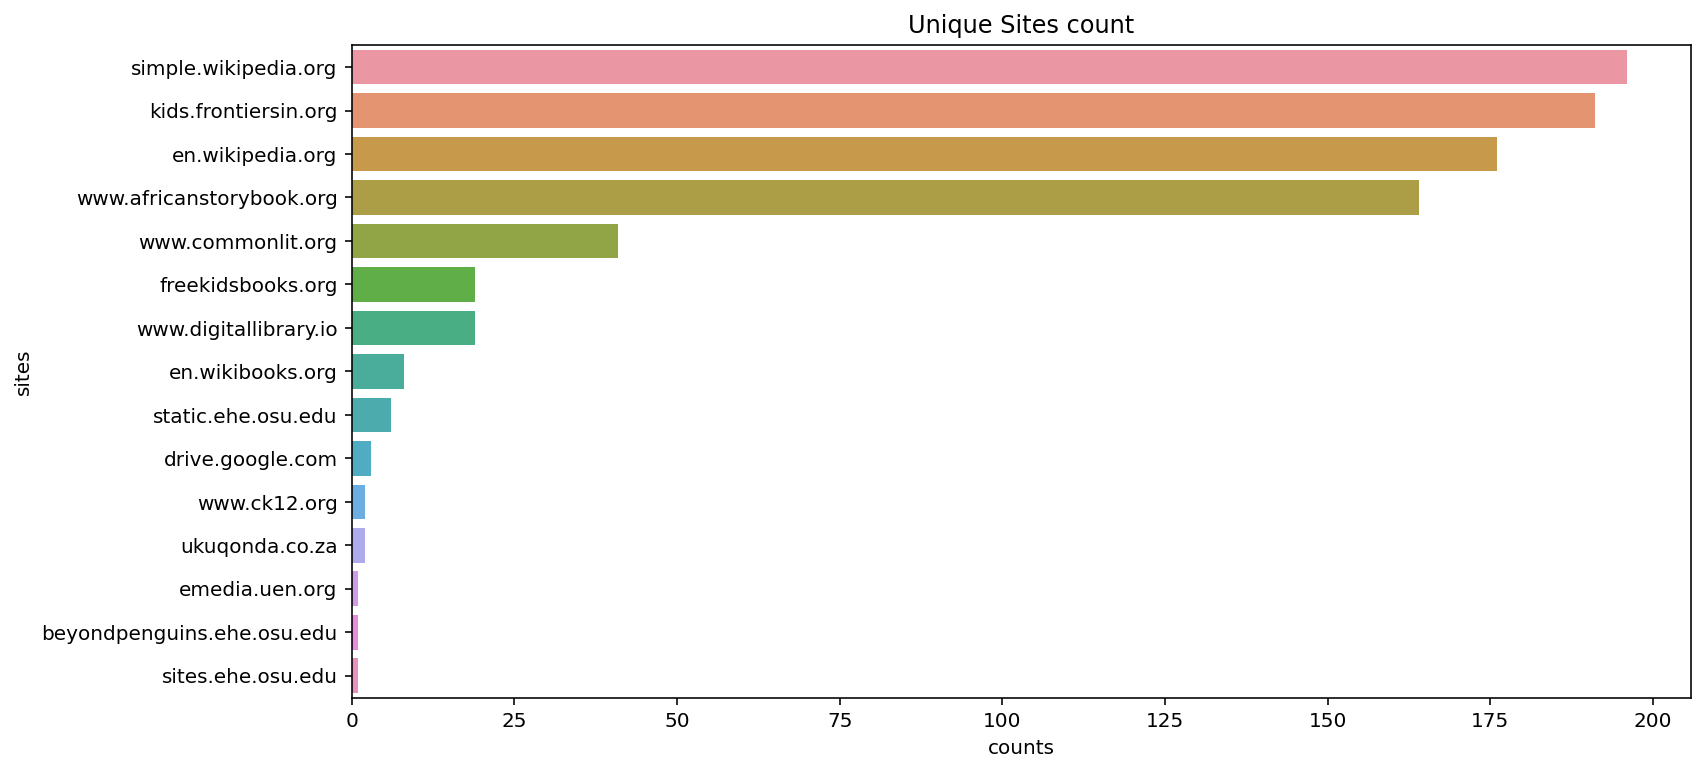

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data= urls_counts_df, x= 'counts', y= 'sites')
plt.title('Unique Sites count')
plt.show();

## excerpt

**The original text**

In [18]:
train_data['excerpt'][0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

**The cleaned text**

In [19]:
normalize_text(train_data['excerpt'][0])

'young people return ballroom present decidedly change appearance instead interior scene winter landscape floor cover snowwhite canvas lay smoothly rumple bump hillock like real snow field numerous palm evergreen decorate room powder flour strew tuft cotton like snow also diamond dust lightly sprinkle glitter crystal icicle hang branch end room wall hang beautiful bearskin rug rug prize one girl one boy game girl gather one end room boy one end call north pole south pole player give small flag plant reach pole would easy matter traveller oblige wear snowshoe'

**Adding cleat text in the data frame**

In [20]:
train_data['clean_text'] = [normalize_text(sent) for sent in train_data['excerpt']]
train_data.head()

,id,url_legal,license,excerpt,target,standard_error,clean_text
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,young people return ballroom present decidedly...
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mr fayre somewhat silent eye rest ...
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predict snow depart quickly come two day...
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,outside palace great garden wall round fill fu...
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bear live together house wood ...


In [21]:
# Also we should make text preprocessing on text data
test_data['excerpt'] = [normalize_text(sent) for sent in test_data['excerpt']]

**Frequent words**

In [22]:
# make all clear sentence as a huge text, then tokenize it
words_list = text2words(''.join(sents for sents in train_data['clean_text']))
words_list[:10]


['young',
 'people',
 'return',
 'ballroom',
 'present',
 'decidedly',
 'change',
 'appearance',
 'instead',
 'interior']

In [23]:
# Number of words we have
len(words_list)

244241

In [24]:
# frequent of the most 30 words
words_list_freq = Counter(words_list)
words_list_freq_sorted = sorted(words_list_freq.items(), key=lambda pair: pair[1], reverse=True)

words_list_freq_sorted_df = pd.DataFrame(words_list_freq_sorted, columns=['words', 'counts'])[:30]
words_list_freq_sorted_df.head()

,words,counts
0,one,1858
1,make,1527
2,say,1500
3,go,1458
4,come,1258


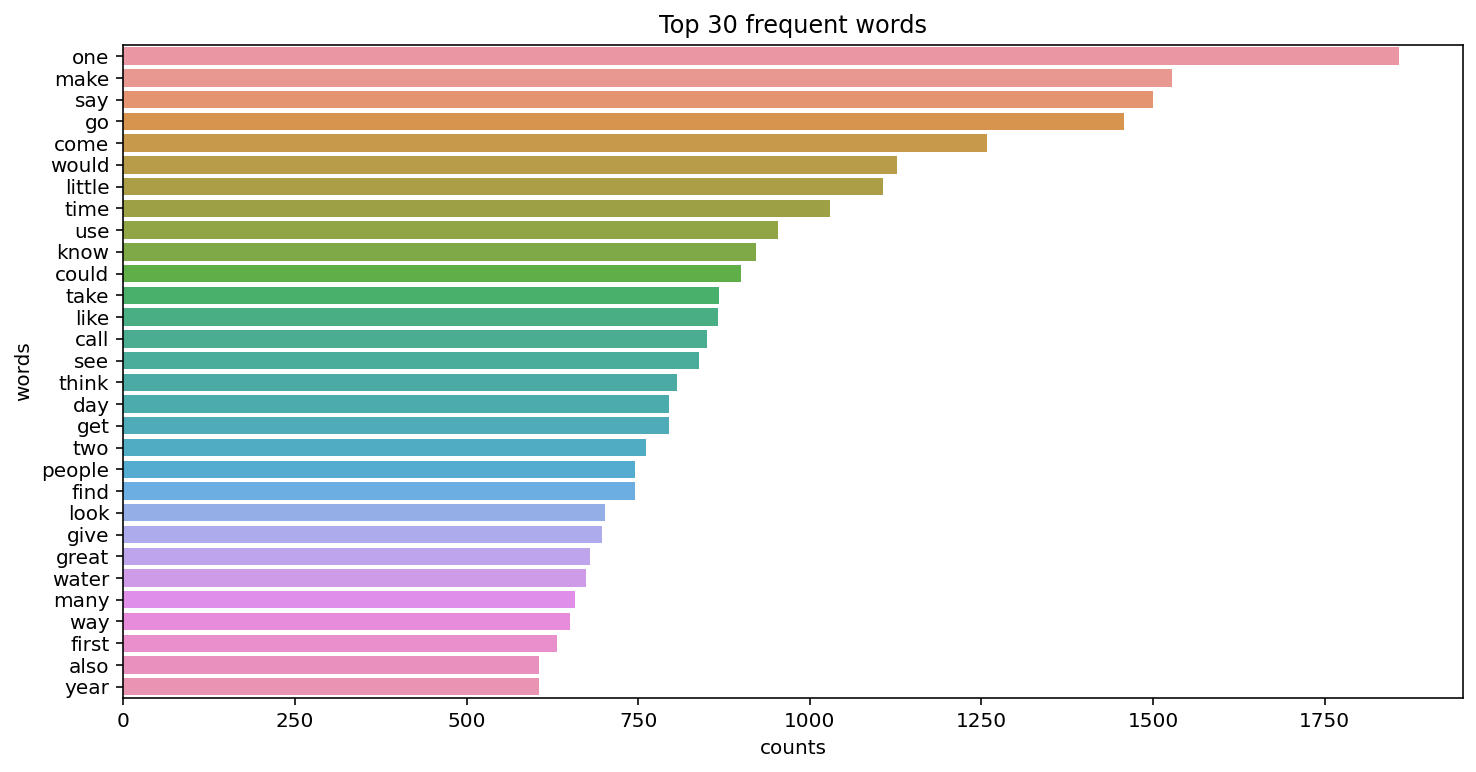

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(data= words_list_freq_sorted_df, y= 'words', x= 'counts')
plt.title('Top 30 frequent words')
plt.show();

**Word Cloud for all words**

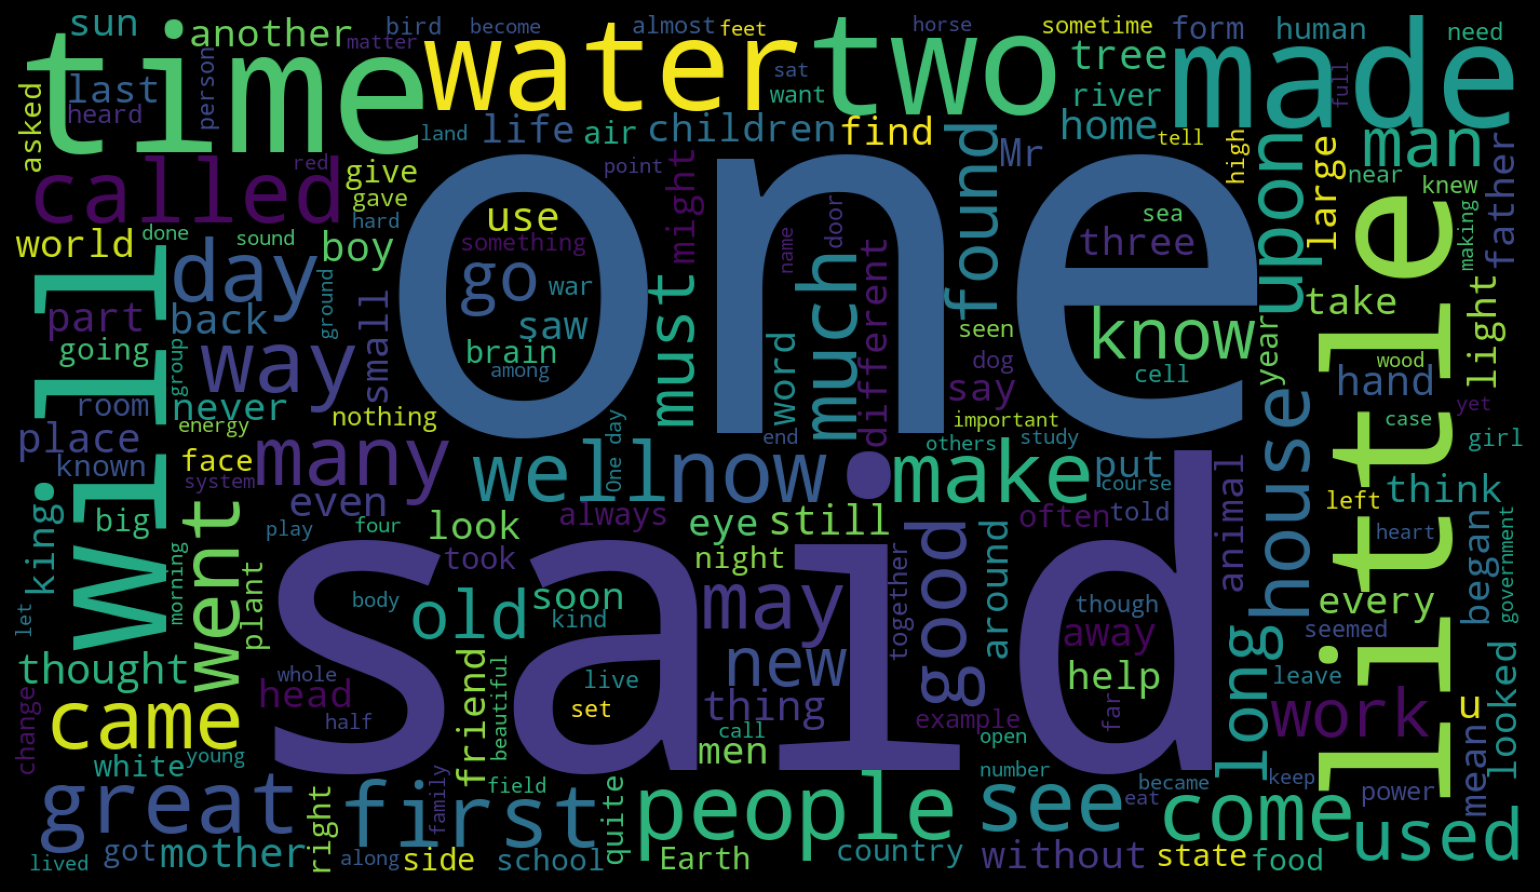

In [26]:
wordcloud(train_data['excerpt'])

**Bigrams**

In [27]:
text= ' '.join(setns for setns in train_data['clean_text'])

In [28]:
two_grams = get_n_grans_count(text, n_grams=2, min_freq=10)
two_grams_df = pd.DataFrame(two_grams.items(), columns= ['two_grams', 'counts']).sort_values(by='counts',ascending=False)
two_grams_df.head()

,two_grams,counts
17,one day,164
98,unite state,101
35,year ago,81
50,little girl,66
10,could see,66


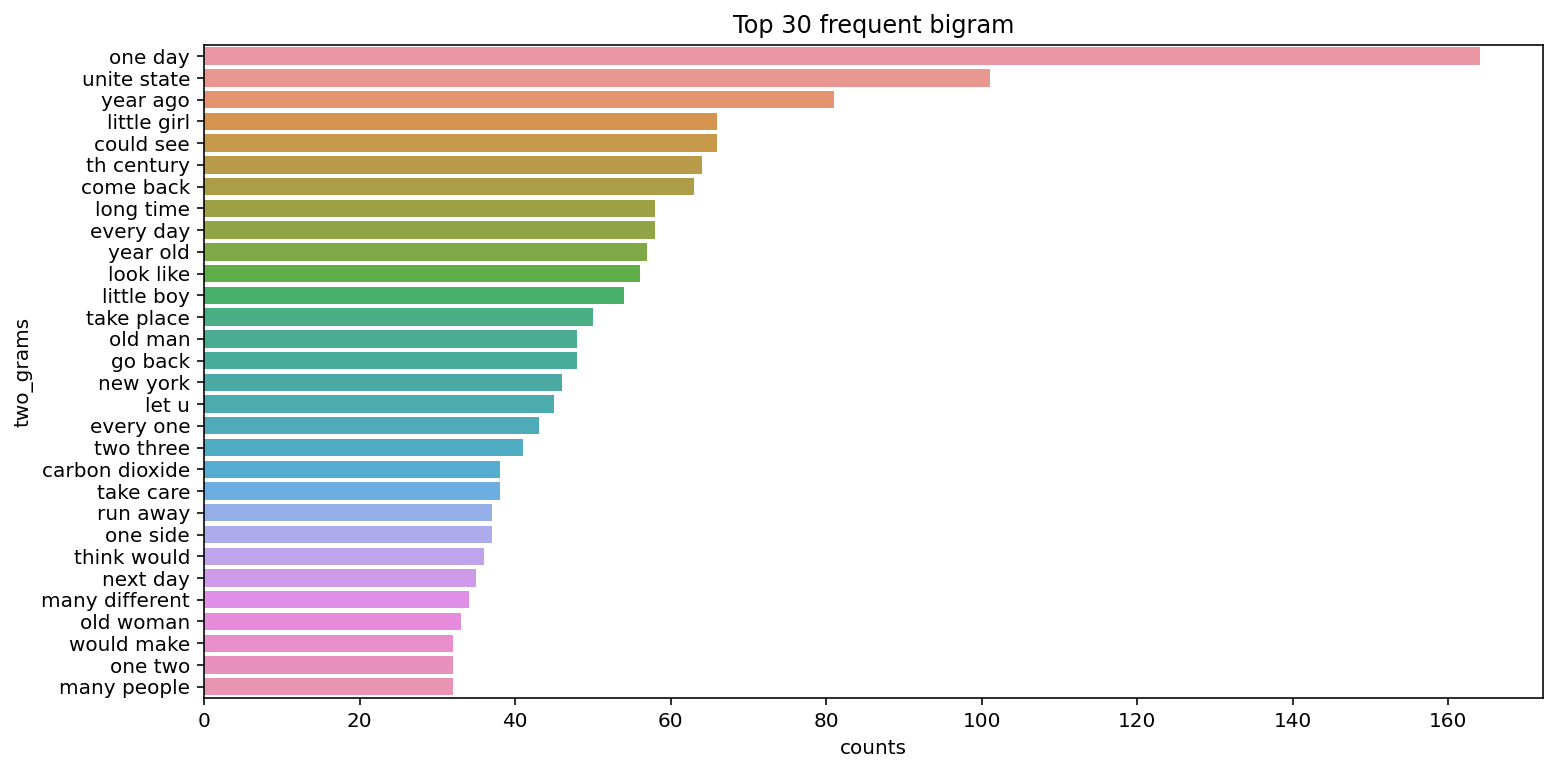

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(data= two_grams_df[:30], y= 'two_grams', x= 'counts')
plt.title('Top 30 frequent bigram')
plt.show();

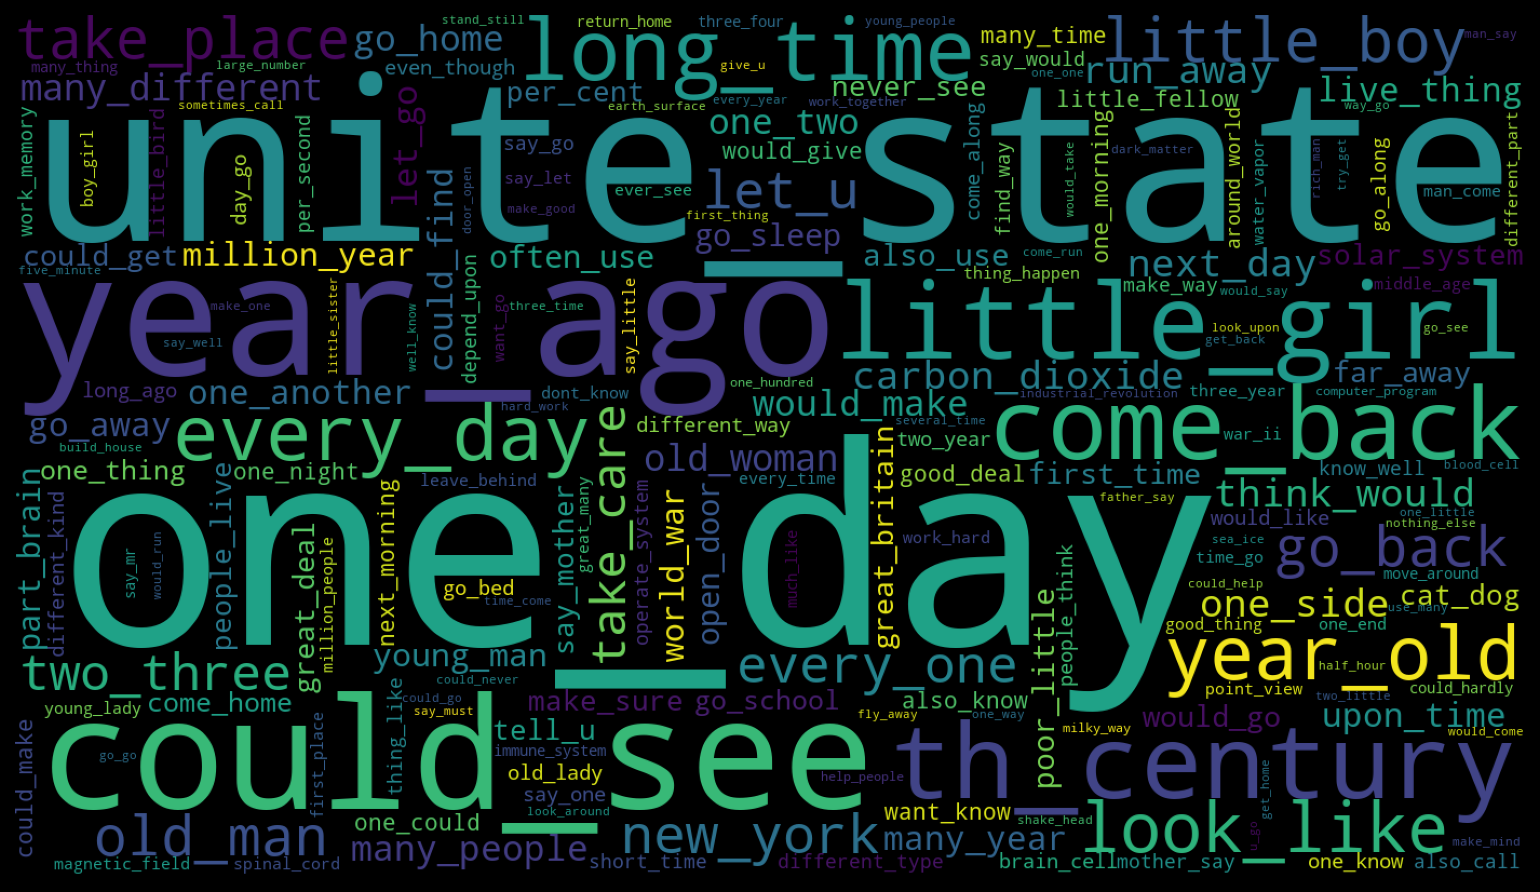

In [30]:
two_grams_wordcloud = {w.replace(' ','_'): c for w,c in two_grams.items()}
wordcloud(two_grams_wordcloud,ngram=2)

### Modeling

Before going further it is important that we split the data into training and validation sets. We can do it using train_test_split from the model_selection module of scikit-learn.

In [31]:
X = train_data['clean_text']
y = train_data['target']
X_train, X_valid, y_train, y_valid =  train_test_split(X, y, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)

In [32]:
print (X_train.shape)
print (X_valid.shape)

(1983,)
(851,)


**Our first model is a simple TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression.**

In [33]:
# Make an Sklearn pipeline for this Ridge Regression
ridge = Ridge(fit_intercept=True, normalize=False)

ridge_pipline = make_pipeline(
    TfidfVectorizer(binary= True, min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)
    , ridge)

# training
ridge_pipline.fit(X_train, y_train)

# Evaluation
y_pred = ridge_pipline.predict(X_valid)
mse_loss = mean_squared_error(y_pred, y_valid)

print(f"MSE Loss using Ridge and TfIdfVectorizer: {mse_loss}")

MSE Loss using Ridge and TfIdfVectorizer: 0.5305239527005301


In [34]:
# Make an Sklearn pipeline for this xgboost Regression
xgboost = xgb.XGBRegressor(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

xgboost_pipline = make_pipeline(
    TfidfVectorizer(binary= True, min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)
    , xgboost)

# training
xgboost_pipline.fit(X_train, y_train)

# Evaluation
y_pred = xgboost_pipline.predict(X_valid)
mse_loss = mean_squared_error(y_pred, y_valid)

print(f"MSE Loss using xgboost and TfIdfVectorizer: {mse_loss}")

MSE Loss using xgboost and TfIdfVectorizer: 0.6878776098637064


**Seems like no luck with XGBoost!**

### Submission

In [35]:
test_text = test_data['excerpt']
test_pred = ridge_pipline.predict(test_text)

submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['target'] = test_pred
submission.to_csv("submission.csv", index=False)
submission

,id,target
0,c0f722661,-1.466284
1,f0953f0a5,-0.820525
2,0df072751,-0.696446
3,04caf4e0c,-1.800541
4,0e63f8bea,-1.296275
5,12537fe78,-0.775793
6,965e592c0,0.252325
